In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.linear_model import Lasso ,Ridge
from sklearn.metrics import  mean_squared_error as MSE
from sklearn.model_selection import train_test_split,GridSearchCV
from pandas.plotting import scatter_matrix

from xgboost import plot_tree
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Data Load

In [2]:
origin_train = pd.read_csv("train.csv")
origin_test = pd.read_csv('test.csv')
print(list(origin_train.columns))

['date_time', 'deg_C', 'relative_humidity', 'absolute_humidity', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']


In [28]:
print(origin_train['date_time'].head())
print(origin_train['date_time'].tail())
print(origin_test['date_time'].head())
print(origin_test['date_time'].tail())


0    2010-03-10 18:00:00
1    2010-03-10 19:00:00
2    2010-03-10 20:00:00
3    2010-03-10 21:00:00
4    2010-03-10 22:00:00
Name: date_time, dtype: object
7106    2010-12-31 20:00:00
7107    2010-12-31 21:00:00
7108    2010-12-31 22:00:00
7109    2010-12-31 23:00:00
7110    2011-01-01 00:00:00
Name: date_time, dtype: object
0    2011-01-01 00:00:00
1    2011-01-01 01:00:00
2    2011-01-01 02:00:00
3    2011-01-01 03:00:00
4    2011-01-01 04:00:00
Name: date_time, dtype: object
2242    2011-04-04 10:00:00
2243    2011-04-04 11:00:00
2244    2011-04-04 12:00:00
2245    2011-04-04 13:00:00
2246    2011-04-04 14:00:00
Name: date_time, dtype: object


#function

In [3]:
def show_corr(df):
    corr_matrix = df.corr()[['target_carbon_monoxide','target_benzene','target_nitrogen_oxides']].T
    corr_matrix = corr_matrix.drop(columns =['target_carbon_monoxide','target_benzene','target_nitrogen_oxides'],axis = 1 )
    plt.matshow(np.array(corr_matrix))
    plt.colorbar()
    plt.show()
    print(corr_matrix)

def df_to_x_y(df):
    y_train = df[['target_carbon_monoxide','target_benzene','target_nitrogen_oxides']]
    x_train = df.drop(columns= ['target_carbon_monoxide','target_benzene','target_nitrogen_oxides'],axis = 1)
    x_train, x_valid , y_train,y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=23)
    return x_train,y_train, x_valid, y_valid

def model_fit_kfold_grid_search (x_train,y_train,x_valid, y_valid):

    y_train_carbon_monoxide = y_train['target_carbon_monoxide']
    y_train_target_benzene = y_train['target_benzene']
    y_train_target_nitrogen_oxides = y_train['target_nitrogen_oxides']

    

    parameter = dict(n_estimators=100,
    objective='reg:squarederror',booster='gbtree',n_jobs=5,
    nthread=None,gamma=0, min_child_weight=1, max_delta_step=0,
    subsample=0.8, colsample_bytree=0.8)

    grid_searchs_parameter = {
              'max_depth': [i for i in range(7)], # 
              'learning_rate': [0.005,0.01, 0.02, 0.05, 0.1]
    }

    model_c = GridSearchCV(xgb.XGBRegressor(**parameter),param_grid= grid_searchs_parameter,cv= 3)
    model_t = GridSearchCV(xgb.XGBRegressor(**parameter),param_grid= grid_searchs_parameter,cv= 3)
    model_n = GridSearchCV(xgb.XGBRegressor(**parameter),param_grid= grid_searchs_parameter,cv= 3)


    model_c.fit(x_train,y_train_carbon_monoxide)
    model_t.fit(x_train,y_train_target_benzene)
    model_n.fit(x_train,y_train_target_nitrogen_oxides)

    result_c = model_c.predict(x_valid)
    result_t = model_t.predict(x_valid)
    result_n = model_n.predict(x_valid)

    max_depth_list = []
    learning_rate_list = []

    for i in [model_c,model_t,model_n]:
        best_parameters = i.best_estimator_.get_params()
        print(f'\n model below ')
        for param_name in sorted(grid_searchs_parameter.keys()):
            print(f"\n {(param_name, best_parameters[param_name])}")
            if param_name =='max_depth':
                max_depth_list.append(best_parameters[param_name])
            elif param_name =='learning_rate':
                learning_rate_list.append(best_parameters[param_name])
    return max_depth_list, learning_rate_list


def model_fit_kfold (x_train,y_train,x_valid, y_valid , max_depth_list = None , learning_rate_list = None ,type = 'train'):

    y_train_carbon_monoxide = y_train['target_carbon_monoxide']
    y_train_target_benzene = y_train['target_benzene']
    y_train_target_nitrogen_oxides = y_train['target_nitrogen_oxides']

    y_valid_carbon_monoxide  = y_valid['target_carbon_monoxide']
    y_valid_target_benzene  = y_valid['target_benzene']
    y_valid_target_nitrogen_oxides  = y_valid['target_nitrogen_oxides']

    parameter = dict(n_estimators=100,
    objective='reg:squarederror',booster='gbtree',n_jobs=10,
    nthread=None,gamma=0, min_child_weight=1, max_delta_step=0,
    subsample=0.8, colsample_bytree=0.8)

    if max_depth_list == None and learning_rate_list == None :
        model_c = xgb.XGBRegressor(**parameter)
        model_t = xgb.XGBRegressor(**parameter)
        model_n = xgb.XGBRegressor(**parameter)
    else :
        model_c = xgb.XGBRegressor(max_depth = max_depth_list[0],learning_rate = learning_rate_list[0] ,**parameter)
        model_t = xgb.XGBRegressor(max_depth = max_depth_list[1],learning_rate = learning_rate_list[1] ,**parameter)
        model_n = xgb.XGBRegressor(max_depth = max_depth_list[2],learning_rate = learning_rate_list[2] ,**parameter)

    fit_parameter = dict(early_stopping_rounds = 15, eval_metric = ['rmsle'])
    model_c.fit(x_train,y_train_carbon_monoxide,eval_set = [(x_valid, y_valid_carbon_monoxide)],**fit_parameter)
    model_t.fit(x_train,y_train_target_benzene,eval_set = [(x_valid, y_valid_target_benzene)],**fit_parameter)
    model_n.fit(x_train,y_train_target_nitrogen_oxides,eval_set = [(x_valid, y_valid_target_nitrogen_oxides)],**fit_parameter)

    result_c = model_c.predict(x_valid)
    result_t = model_t.predict(x_valid)
    result_n = model_n.predict(x_valid)

    mse_c = MSE(y_valid.iloc[:,0],result_c)
    mse_t = MSE(y_valid.iloc[:,1],result_t)
    mse_n = MSE(y_valid.iloc[:,2],result_n)

    if type == 'train':
        plt.figure(figsize=(20,6))
        plt.plot(x_valid.columns,model_c.feature_importances_)
        plt.plot(x_valid.columns,model_t.feature_importances_)
        plt.plot(x_valid.columns,model_n.feature_importances_)
        print(model_n.feature_importances_.sum())
        plt.show()

    if type == 'test':
        return  model_c ,model_t ,model_n

# none try

[0]	validation_0-rmsle:0.45896
[1]	validation_0-rmsle:0.31002
[2]	validation_0-rmsle:0.22824
[3]	validation_0-rmsle:0.18479
[4]	validation_0-rmsle:0.16029
[5]	validation_0-rmsle:0.14775
[6]	validation_0-rmsle:0.14088
[7]	validation_0-rmsle:0.13811
[8]	validation_0-rmsle:0.13594
[9]	validation_0-rmsle:0.13415
[10]	validation_0-rmsle:0.13287
[11]	validation_0-rmsle:0.13156
[12]	validation_0-rmsle:0.13098
[13]	validation_0-rmsle:0.13141
[14]	validation_0-rmsle:0.13293
[15]	validation_0-rmsle:0.13274
[16]	validation_0-rmsle:0.13285
[17]	validation_0-rmsle:0.13271
[18]	validation_0-rmsle:0.13252
[19]	validation_0-rmsle:0.13289
[20]	validation_0-rmsle:0.13307
[21]	validation_0-rmsle:0.13279
[22]	validation_0-rmsle:0.13292
[23]	validation_0-rmsle:0.13282
[24]	validation_0-rmsle:0.13267
[25]	validation_0-rmsle:0.13251
[26]	validation_0-rmsle:0.13263
[0]	validation_0-rmsle:0.85830
[1]	validation_0-rmsle:0.51390
[2]	validation_0-rmsle:0.33716
[3]	validation_0-rmsle:0.23452
[4]	validation_0-rmsle

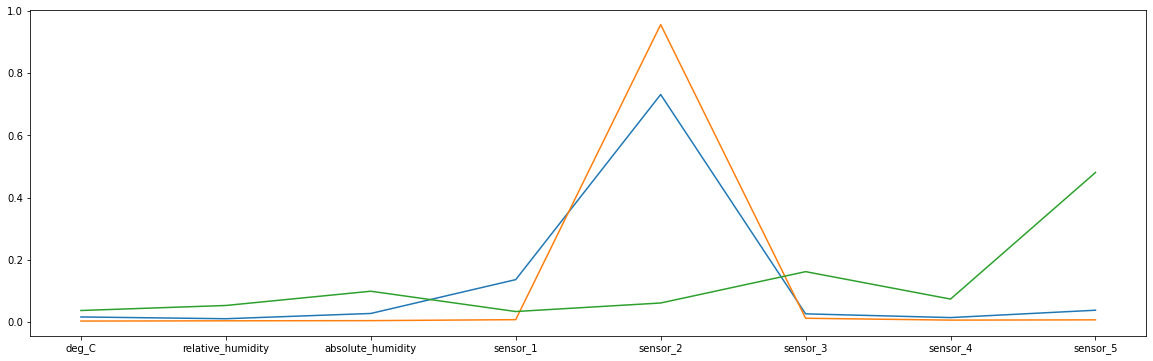

In [4]:
none_train = origin_train.copy()

x_train,y_train,x_valid, y_valid = df_to_x_y(none_train.drop(['date_time'],axis = 1))
xgb_mone = model_fit_kfold(x_train, y_train, x_valid, y_valid, max_depth_list=None , learning_rate_list=None,type = 'train')

# Feature Analysis

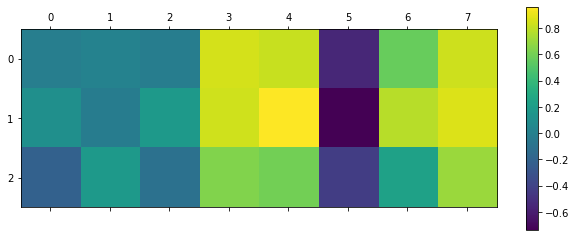

                           deg_C  relative_humidity  absolute_humidity  \
target_carbon_monoxide -0.007503           0.016589          -0.013756   
target_benzene          0.109757          -0.022895           0.186293   
target_nitrogen_oxides -0.205984           0.178608          -0.101911   

                        sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  
target_carbon_monoxide  0.857215  0.821025 -0.547567  0.571412  0.834501  
target_benzene          0.842534  0.964440 -0.735545  0.783750  0.877662  
target_nitrogen_oxides  0.643044  0.604795 -0.427622  0.235662  0.708270  


In [5]:
show_corr(none_train)

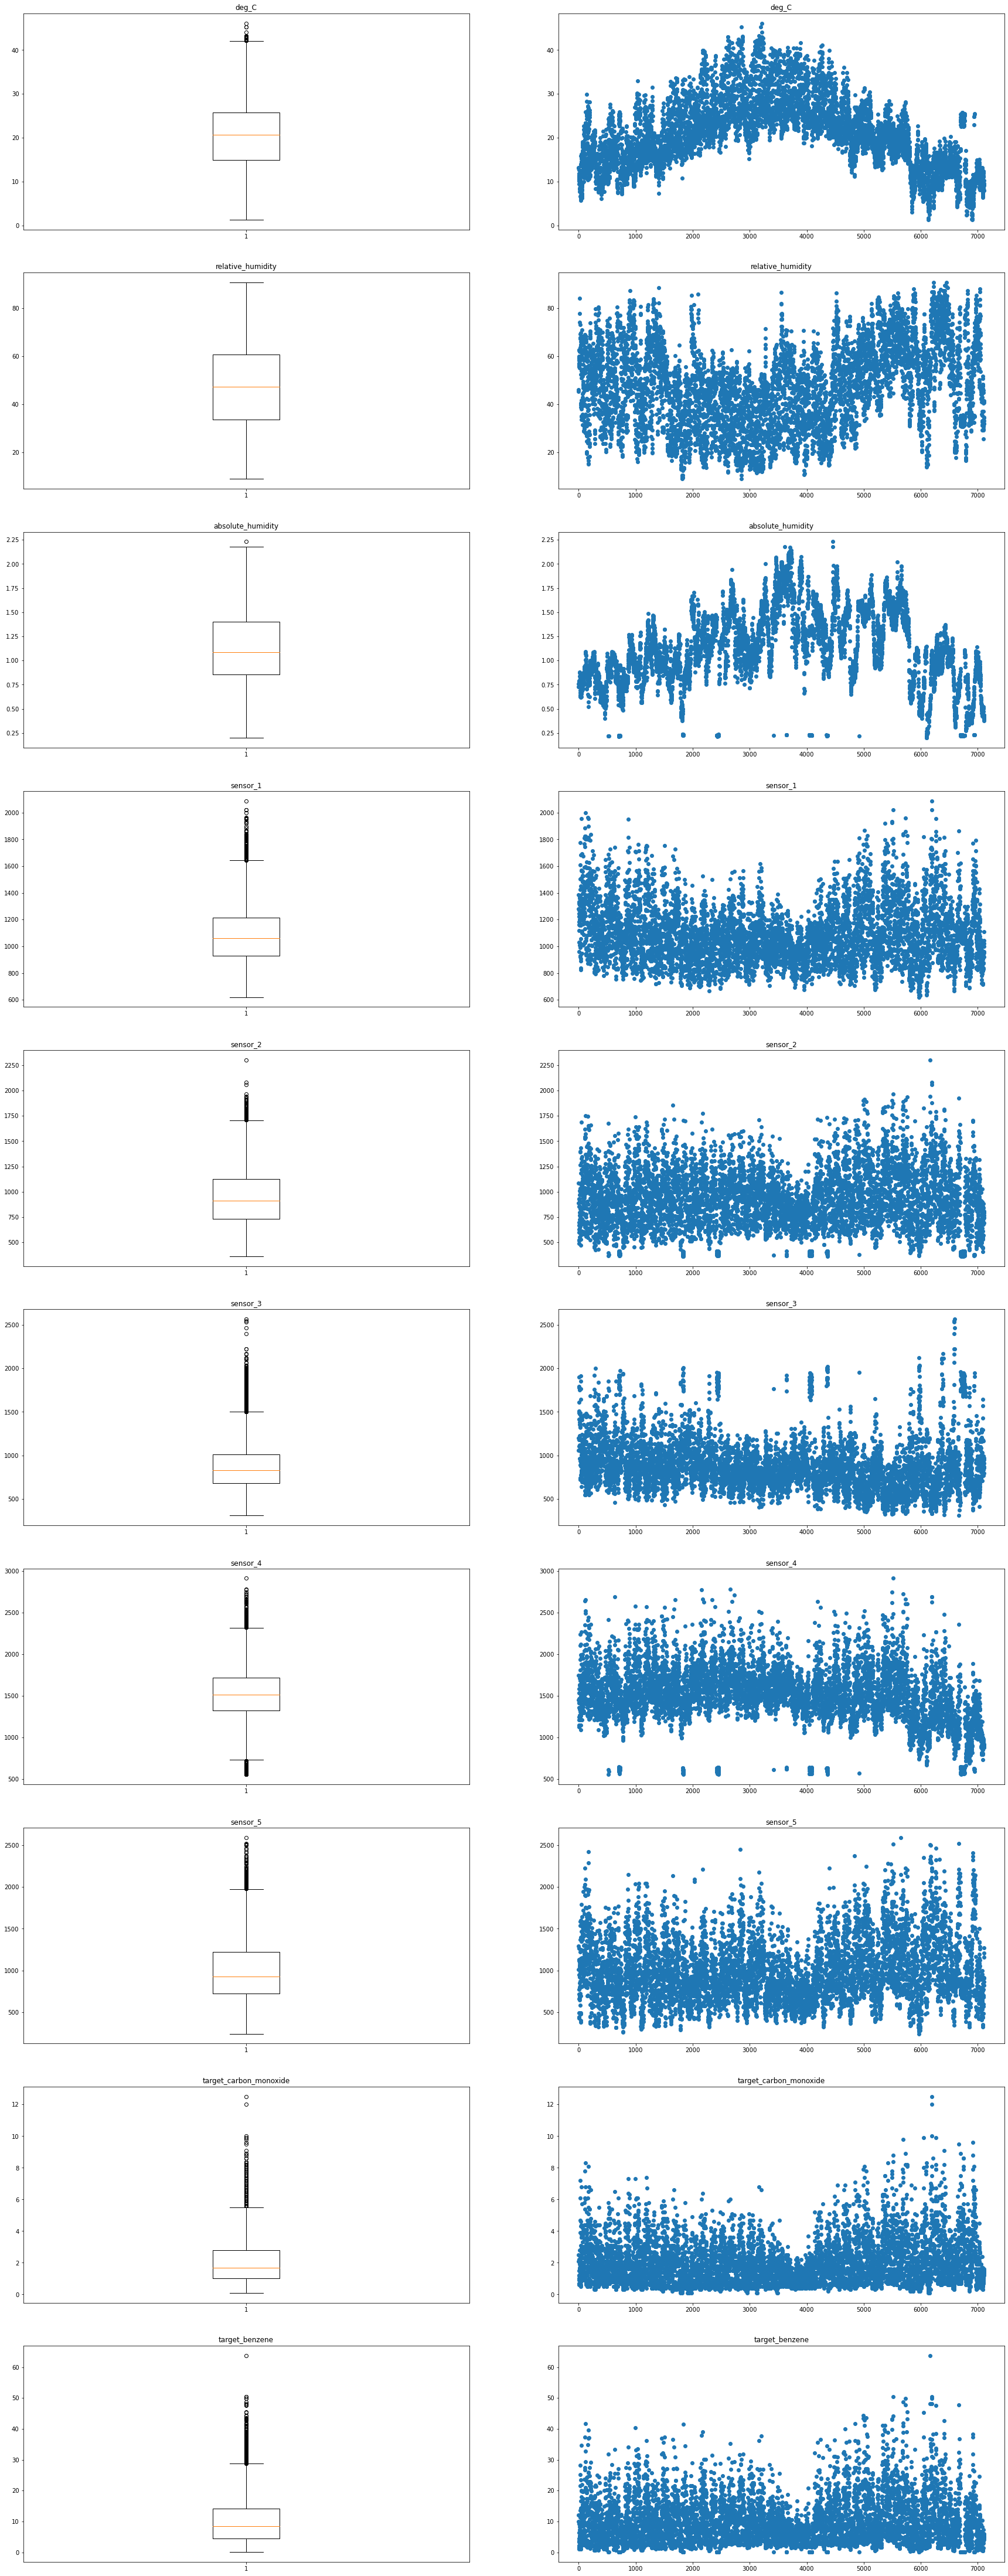

In [6]:

col = none_train.columns
fig, axes = plt.subplots(len(col)-2, 2)
fig.set_figwidth(30)
fig.set_figheight(80)
for i in range(1,len(col)-1):
    i = int(i)
    axes[i-1,0].boxplot(none_train.iloc[:,i])
    axes[i-1,0].set_title(col[i])
    axes[i-1,1].scatter(list(range(len(none_train))),none_train.iloc[:,i])
    axes[i-1,1].set_title(col[i])
plt.show()


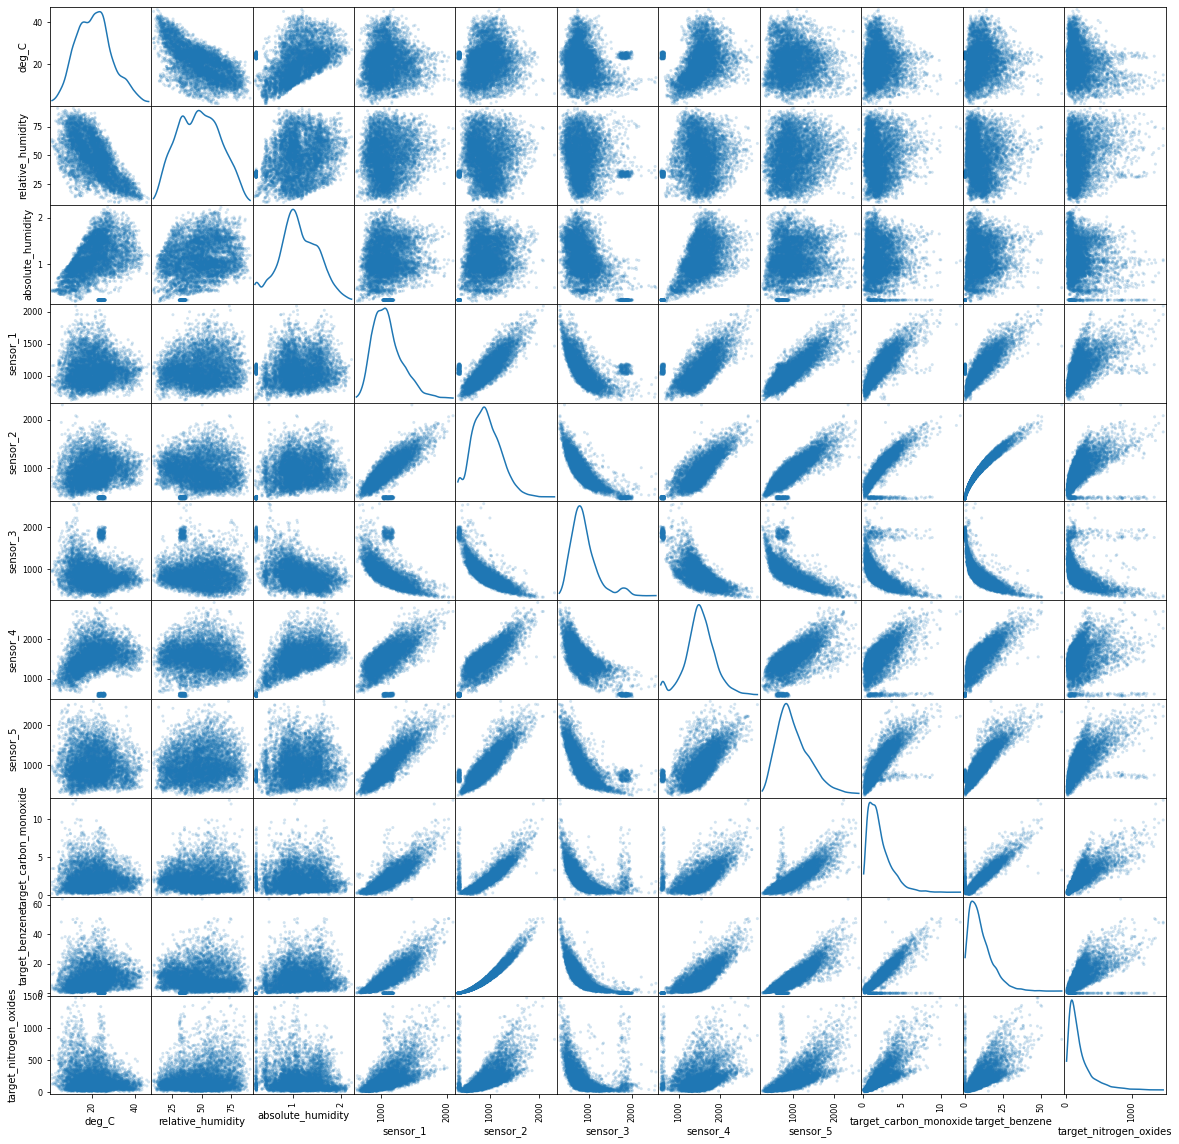

In [7]:

scatter_matrix(none_train, alpha = 0.2, figsize = (20, 20), diagonal = 'kde')
plt.show()

In [8]:
print(len(none_train))
for i in  range(1,len(none_train.columns)):
    target = none_train.iloc[:,i]
    scope = target.mean()+(target.std()*2)
    column_name = none_train.columns[i]
    none_train = none_train[none_train[column_name]<float(scope)]
    print(f'{none_train.columns[i]}:{len(none_train)}')
clean_df = none_train

7111
deg_C:6873
relative_humidity:6775
absolute_humidity:6638
sensor_1:6368
sensor_2:6200
sensor_3:5846
sensor_4:5706
sensor_5:5513
target_carbon_monoxide:5276
target_benzene:5082
target_nitrogen_oxides:4809


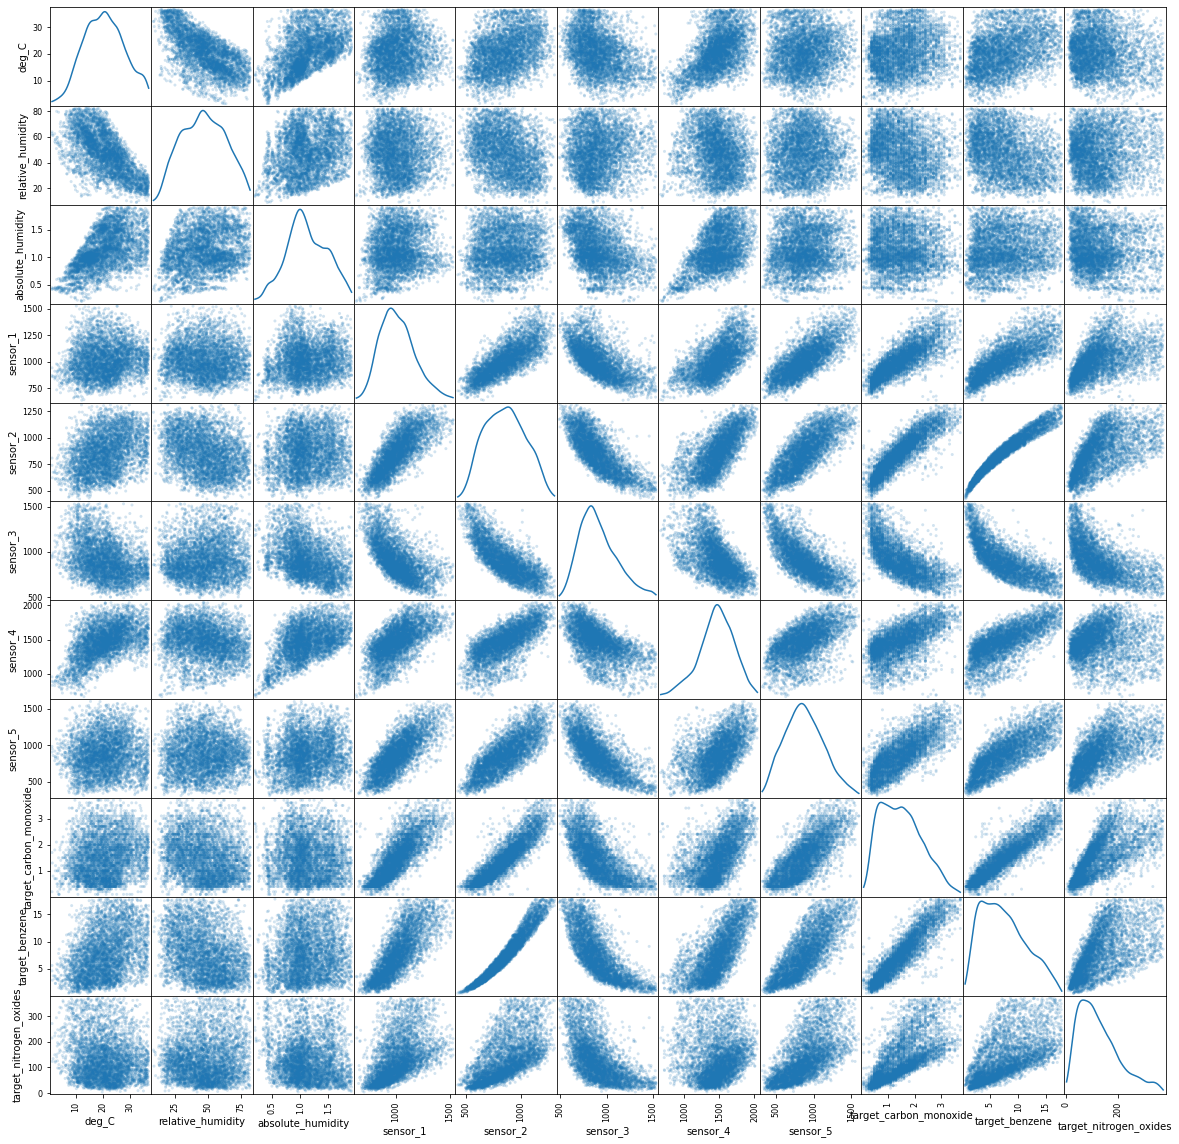

In [9]:
scatter_matrix(clean_df, alpha = 0.2, figsize = (20, 20), diagonal = 'kde')
plt.show()

## data engine

In [10]:
def feature_engine(df):
    df = df.reset_index(drop = True)
    # datetime_processing
    datatime = df['date_time']
    df['hour'] = pd.to_datetime(df['date_time']).dt.hour
    df['hour'] = abs(df['hour']-12)/12

    df['month'] = pd.to_datetime(df['date_time']).dt.month
    df['month'] = abs(df['hour']-6)/6

    df = df.drop(['date_time'],axis = 1)
    # mean of senser
    df['1345_mean'] = round((df['sensor_1'] + df['sensor_3']+ df['sensor_4'] + df['sensor_5'])/4,1)

    # adjust mean_deg_c
    gap = 1

    mean_deg_c = df['deg_C'].copy()
    change = 0
    for i in range(1,len(mean_deg_c)-1):
        #increase too much
        if mean_deg_c[i-1] - mean_deg_c[i] >  gap:
            mean_deg_c[i] = mean_deg_c[i-1] - gap
            change +=1
        #decrease too much
        if mean_deg_c[i-1] - mean_deg_c[i] <  gap*-1:
            mean_deg_c[i] = mean_deg_c[i-1] + gap
            change +=1
    df['mean_deg_c'] = mean_deg_c
    df = df.drop(['deg_C'],axis = 1)
    df = pd.DataFrame(df)
    return df ,datatime

In [11]:
df = clean_df.copy()
df ,datatime = feature_engine(df)
x_train,y_train,x_valid, y_valid = df_to_x_y(df)
x_train.head()

relative_humidity  absolute_humidity  sensor_1  sensor_2  sensor_3  \
1737               32.2             1.1605    1071.4    1066.8     775.7   
2542               48.2             1.4337    1096.9     947.0     724.0   
2937               28.6             1.2770     819.1     613.8    1108.8   
952                41.2             1.0324    1056.6    1073.8     891.4   
337                46.9             0.6280     898.6     547.0    1496.0   

      sensor_4  sensor_5      hour     month  1345_mean  mean_deg_c  
1737    1734.7    1160.9  0.833333  0.861111     1185.7        25.0  
2542    1775.7    1168.0  0.416667  0.930556     1191.2        24.8  
2937    1402.8     427.2  0.083333  0.986111      939.5        30.0  
952     1558.7     762.3  0.500000  0.916667     1067.2        21.9  
337     1176.1     486.9  0.666667  0.888889     1014.4        10.7

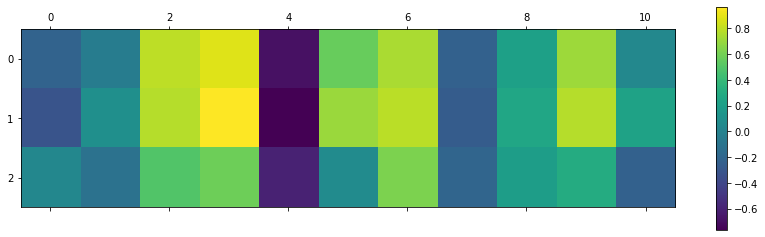

                        relative_humidity  absolute_humidity  sensor_1  \
target_carbon_monoxide          -0.210953          -0.038398  0.795620   
target_benzene                  -0.312833           0.102626  0.779144   
target_nitrogen_oxides           0.039679          -0.108683  0.496732   

                        sensor_2  sensor_3  sensor_4  sensor_5      hour  \
target_carbon_monoxide  0.883970 -0.684514  0.569009  0.749277 -0.223436   
target_benzene          0.969053 -0.763704  0.711202  0.790243 -0.261130   
target_nitrogen_oxides  0.587839 -0.598735  0.073788  0.626631 -0.199894   

                           month  1345_mean  mean_deg_c  
target_carbon_monoxide  0.223436   0.715985    0.044312  
target_benzene          0.261130   0.775873    0.235742  
target_nitrogen_oxides  0.199894   0.303893   -0.224408  


In [12]:
show_corr(df)


 model below 

 ('learning_rate', 0.1)

 ('max_depth', 5)

 model below 

 ('learning_rate', 0.05)

 ('max_depth', 6)

 model below 

 ('learning_rate', 0.05)

 ('max_depth', 6)
[0]	validation_0-rmsle:0.48635
[1]	validation_0-rmsle:0.42721
[2]	validation_0-rmsle:0.37642
[3]	validation_0-rmsle:0.33405
[4]	validation_0-rmsle:0.29975
[5]	validation_0-rmsle:0.26917
[6]	validation_0-rmsle:0.24392
[7]	validation_0-rmsle:0.22263
[8]	validation_0-rmsle:0.20478
[9]	validation_0-rmsle:0.18936
[10]	validation_0-rmsle:0.17629
[11]	validation_0-rmsle:0.16429
[12]	validation_0-rmsle:0.15470
[13]	validation_0-rmsle:0.14613
[14]	validation_0-rmsle:0.13933
[15]	validation_0-rmsle:0.13337
[16]	validation_0-rmsle:0.12885
[17]	validation_0-rmsle:0.12502
[18]	validation_0-rmsle:0.12173
[19]	validation_0-rmsle:0.11874
[20]	validation_0-rmsle:0.11638
[21]	validation_0-rmsle:0.11429
[22]	validation_0-rmsle:0.11261
[23]	validation_0-rmsle:0.11146
[24]	validation_0-rmsle:0.11048
[25]	validation_0-rmsle:0.10963

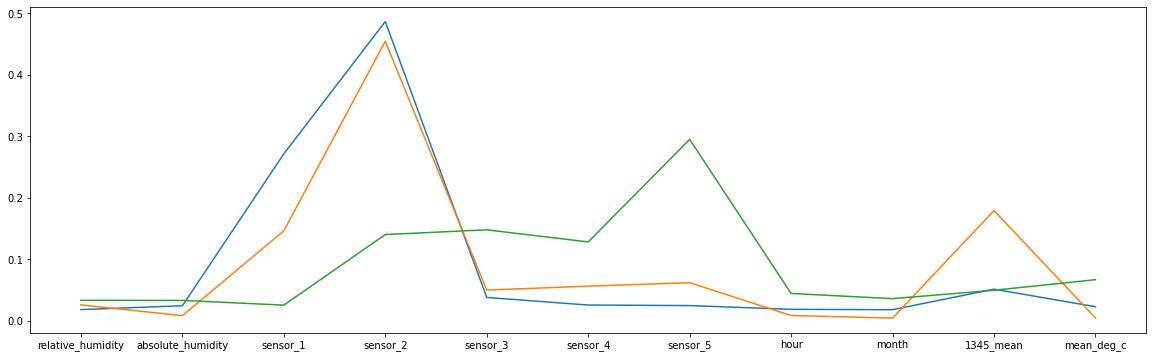

In [13]:
max_depth_list, learning_rate_list = model_fit_kfold_grid_search(x_train,y_train,x_valid, y_valid)
model_fit_kfold(x_train,y_train,x_valid, y_valid,max_depth_list, learning_rate_list)

In [14]:
xgb_reg0,xgb_reg1,xgb_reg2 = model_fit_kfold(x_train,y_train,x_valid, y_valid,max_depth_list, learning_rate_list,type = 'test')

[0]	validation_0-rmsle:0.48635
[1]	validation_0-rmsle:0.42721
[2]	validation_0-rmsle:0.37642
[3]	validation_0-rmsle:0.33405
[4]	validation_0-rmsle:0.29975
[5]	validation_0-rmsle:0.26917
[6]	validation_0-rmsle:0.24392
[7]	validation_0-rmsle:0.22263
[8]	validation_0-rmsle:0.20478
[9]	validation_0-rmsle:0.18936
[10]	validation_0-rmsle:0.17629
[11]	validation_0-rmsle:0.16429
[12]	validation_0-rmsle:0.15470
[13]	validation_0-rmsle:0.14613
[14]	validation_0-rmsle:0.13933
[15]	validation_0-rmsle:0.13337
[16]	validation_0-rmsle:0.12885
[17]	validation_0-rmsle:0.12502
[18]	validation_0-rmsle:0.12173
[19]	validation_0-rmsle:0.11874
[20]	validation_0-rmsle:0.11638
[21]	validation_0-rmsle:0.11429
[22]	validation_0-rmsle:0.11261
[23]	validation_0-rmsle:0.11146
[24]	validation_0-rmsle:0.11048
[25]	validation_0-rmsle:0.10963
[26]	validation_0-rmsle:0.10919
[27]	validation_0-rmsle:0.10840
[28]	validation_0-rmsle:0.10754
[29]	validation_0-rmsle:0.10703
[30]	validation_0-rmsle:0.10642
[31]	validation_0-

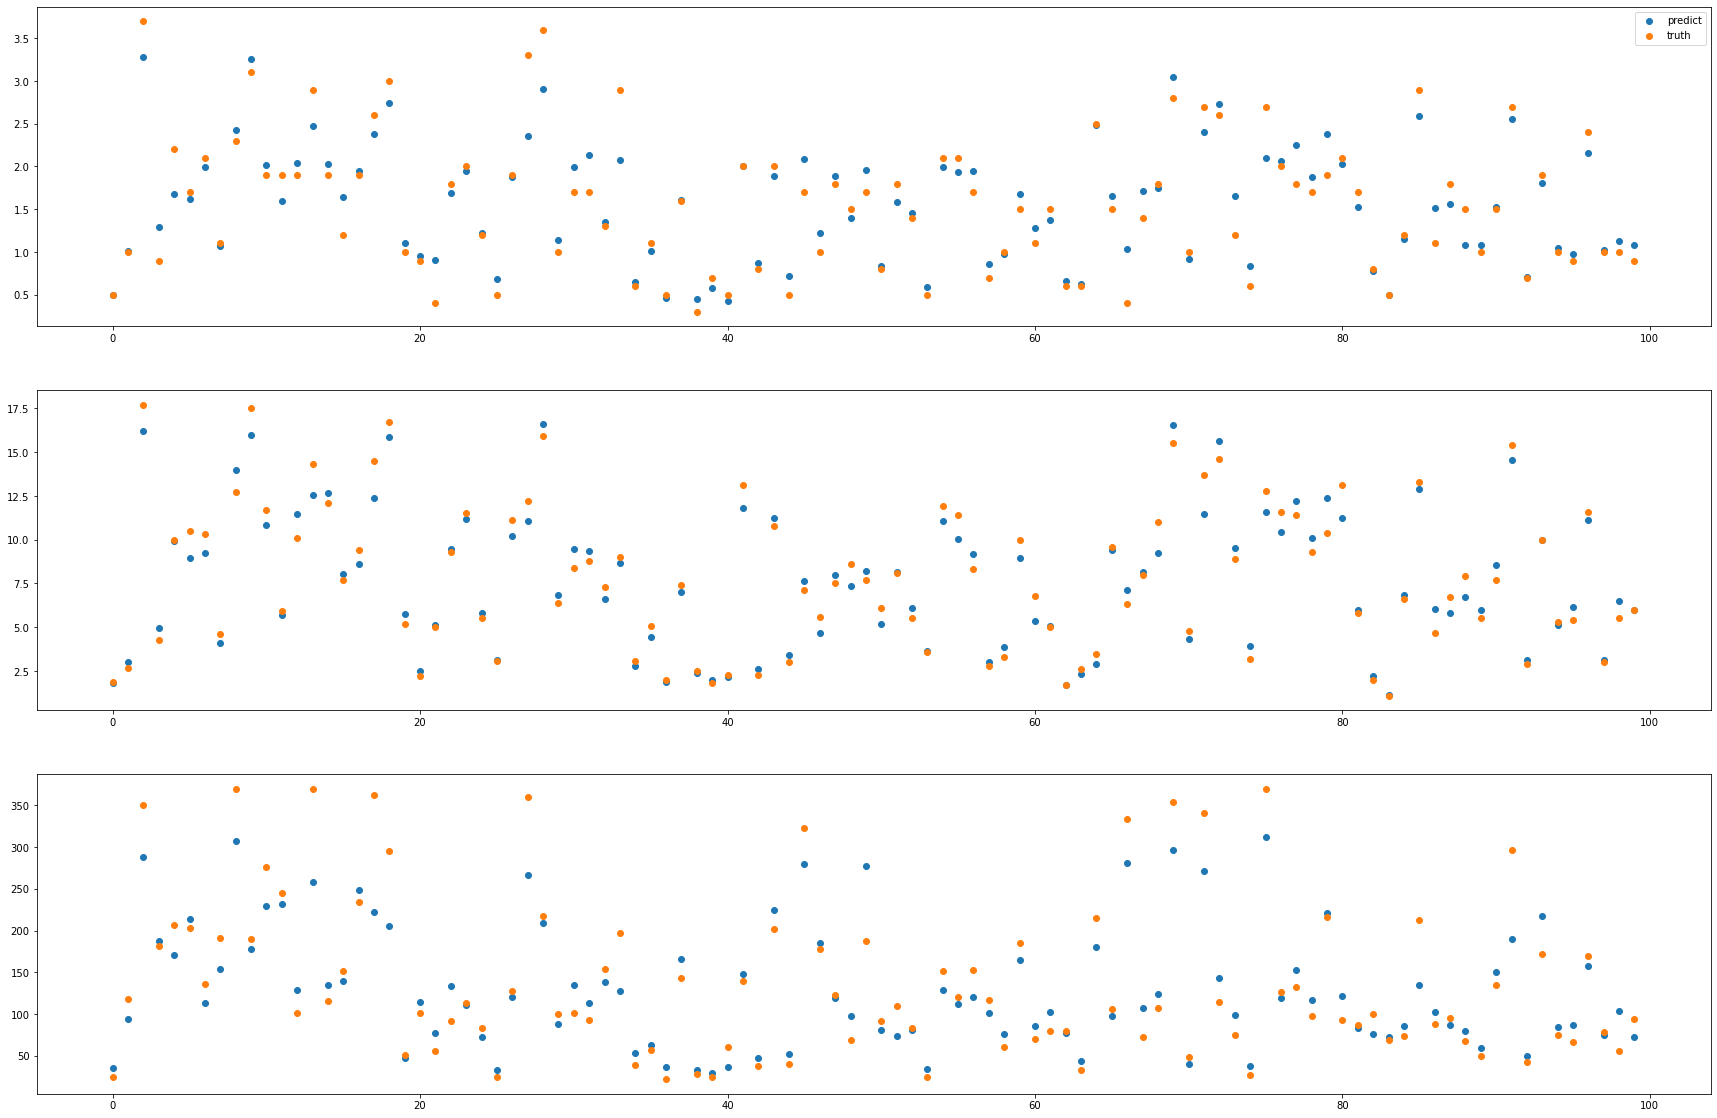

In [15]:
xgb_reg0_pred = xgb_reg0.predict(x_valid[200:300])
xgb_reg1_pred = xgb_reg1.predict(x_valid[200:300])
xgb_reg2_pred = xgb_reg2.predict(x_valid[200:300])

x_trick = range(len(xgb_reg0_pred))

fig ,axs = plt.subplots(3)
fig.set_figheight(20)
fig.set_figwidth(30)
axs[0].scatter(x_trick,xgb_reg0_pred,label = 'predict')
axs[0].scatter(x_trick,y_valid['target_carbon_monoxide'][200:300],label = 'truth')
axs[0].legend()
axs[1].scatter(x_trick,xgb_reg1_pred,label = 'predict')
axs[1].scatter(x_trick,y_valid['target_benzene'][200:300],label = 'truth')
axs[2].scatter(x_trick,xgb_reg2_pred,label = 'predict')
axs[2].scatter(x_trick,y_valid['target_nitrogen_oxides'][200:300],label = 'truth')
plt.show()

In [16]:
test_x ,datatime= feature_engine(origin_test.copy())


In [17]:
test_x

relative_humidity  absolute_humidity  sensor_1  sensor_2  sensor_3  \
0                  41.3             0.4375    1108.8     745.7     797.1   
1                  51.7             0.4564    1249.5     864.9     687.9   
2                  51.5             0.4689    1102.6     878.0     693.7   
3                  52.3             0.4693    1139.7     916.2     725.6   
4                  57.5             0.4650    1022.4     838.5     871.5   
...                 ...                ...       ...       ...       ...   
2242               28.7             0.7568    1340.3    1023.9     522.8   
2243               22.5             0.7119    1232.8     955.1     616.1   
2244               19.0             0.6406    1187.7    1052.4     572.8   
2245               12.7             0.5139    1053.2    1009.0     702.0   
2246               13.5             0.5028    1124.6    1078.4     608.2   

      sensor_4  sensor_5      hour     month  1345_mean  mean_deg_c  
0        880.0    1273.1  1.000000  0.833333     1014.8         8.0  
1        972.8    1714.0  0.916667  0.847222     1156.0         7.0  
2        941.9    1300.8  0.833333  0.861111     1009.8         6.0  
3       1011.0    1283.0  0.750000  0.875000     1039.8         5.0  
4        967.0    1142.3  0.666667  0.888889     1000.8         4.5  
...        ...       ...       ...       ...        ...         ...  
2242    1374.0    1659.8  0.166667  0.972222     1224.2        12.1  
2243    1226.1    1269.0  0.083333  0.986111     1086.0        13.1  
2244    1253.4    1081.1  0.000000  1.000000     1023.8        14.1  
2245    1009.8     808.5  0.083333  0.986111      893.4        15.1  
2246    1061.3     816.0  0.166667  0.972222      902.5        27.9  

[2247 rows x 11 columns]

In [22]:
xgb_reg0_pred_test = xgb_reg0.predict(test_x,iteration_range=(0, xgb_reg0.best_iteration))
xgb_reg1_pred_test = xgb_reg1.predict(test_x,iteration_range=(0, xgb_reg1.best_iteration))
xgb_reg2_pred_test = xgb_reg2.predict(test_x,iteration_range=(0, xgb_reg2.best_iteration))

In [23]:
result = pd.DataFrame([datatime,xgb_reg0_pred_test,xgb_reg1_pred_test,xgb_reg2_pred_test]).T
result.columns=['date_time','target_carbon_monoxide','target_benzene','target_nitrogen_oxides']

In [24]:
result.to_csv('sub_0809_04.csv',index = False)